Contents:

1. Module Imports
2. Reading Data into the Notebook
3. Train - Valid - Test split
4. Data Pre-processing
5. Hyperparameter tuning
6. Evaluating test set accuracy with the trained model


In [20]:
!pip install fancyimpute


In [57]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import scipy
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.svm import SVC
from sklearn import preprocessing
import fancyimpute
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB


from sklearn.model_selection import train_test_split

%matplotlib inline



C:\Users\shrey\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [58]:
'''Define a variable that points to this. This will let you avoid typing
the long path everytime you need to use it'''

my_path = 'C:\\Users\\shrey\\Desktop\\ML Asg 2'

# II. Reading data into the notebook

In [59]:
'''We will use the Titanic dataset, as supplied here (Titanic_full.csv).
The same dataset can be downloaded from the Kaggle website. Check the
shape and header of the data you just read in as a dataframe. The use of
f and {} is specific to the recent versions of Python (3.x). You can as 
well type the full path here, and that works too!'''

my_df = pd.read_csv(f'{my_path}/Titanic_full(2).csv')
print(my_df.shape)
my_df.head(3)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [60]:
#Divide train and test set

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


mydf_train_valid,mydf_test = mydf_splitter(my_df,1100)

print(mydf_train_valid.shape,mydf_test.shape)

#We are going to put away the mydf_test for now. 
#We will return to it later.

(1100, 12) (209, 12)


In [61]:
# Extract title from names, then assign to one of five classes.
# [REFERENCE] Function based on code  from: https://www.kaggle.com/startupsci/titanic/titanic-data-science-solutions 
def add_title(data):
    data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    data.Title = data.Title.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 
                                     'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data.Title = data.Title.replace('Mlle', 'Miss')
    data.Title = data.Title.replace('Ms', 'Miss')
    data.Title = data.Title.replace('Mme', 'Mrs')
    
    # Map from strings to numerical variables.
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    
    data.Title = data.Title.map(title_mapping)
    data.Title = data.Title.fillna(0)

    return data



In [62]:
missing_emb_training = mydf_train_valid[pd.isnull(mydf_train_valid.Embarked) == True]
missing_emb_test = mydf_test[pd.isnull(mydf_test.Embarked) == True]
missing_emb_training.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


C:\Users\shrey\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


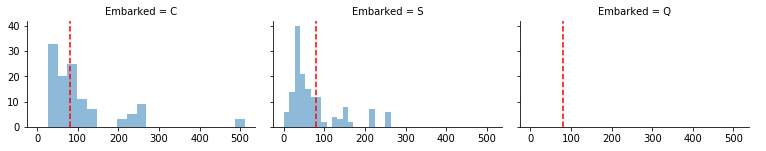

In [63]:
grid = sns.FacetGrid(mydf_train_valid[mydf_train_valid.Pclass == 1], col='Embarked', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Fare', alpha=.5, bins=20)
grid.map(plt.axvline, x=80.0, color='red', ls='dashed')
grid.add_legend();

#Southampton was the most popular port of embarkation

In [64]:
# Recast port of departure as numerical feature. 
def simplify_embark(data):
    # Two missing values, assign Cherbourg as port of departure.
    data.Embarked = data.Embarked.fillna('C')
    
    le = preprocessing.LabelEncoder().fit(data.Embarked)
    data.Embarked = le.transform(data.Embarked)
    
    return data



In [65]:
#We will perform a similar analysis to see if there are any missing fares.

missing_fare_training = mydf_train_valid[np.isnan(mydf_train_valid['Fare'])]
missing_fare_test = mydf_test[np.isnan(mydf_test['Fare'])]

missing_fare_training.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,0,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


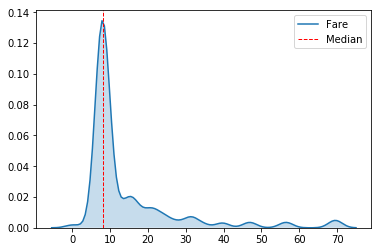

In [66]:
# working with Pclass and Embarked

restricted_training = mydf_train_valid[(mydf_train_valid.Pclass == 3) & (mydf_train_valid.Embarked == 'S')]
restricted_test = mydf_test[(mydf_test.Pclass == 3) & (mydf_test.Embarked == 'S')]
restricted_training = restricted_training[~np.isnan(restricted_training.Fare)] # Leave out poor Mr. Storey
combine = [restricted_training, restricted_test]
combine = pd.concat(combine)

# Find median fare, plot over resulting distribution. 
fare_med = np.median(combine.Fare)

sns.kdeplot(combine.Fare, shade=True)
plt.axvline(fare_med, color='r', ls='dashed', lw='1', label='Median')
plt.legend();


In [67]:
mydf_train_valid['Fare'] = mydf_train_valid['Fare'].fillna(fare_med)

In [68]:
mydf_train_valid['Fare'].isnull().sum()


0

In [69]:
#Cabin has many missing data

missing_cabin_training = np.size(mydf_train_valid.Cabin[pd.isnull(mydf_train_valid.Cabin) == True]) / np.size(mydf_train_valid.Cabin) * 100.0
missing_cabin_test = np.size(mydf_test.Cabin[pd.isnull(mydf_test.Cabin) == True]) / np.size(mydf_test.Cabin) * 100.0

print('Percentage of Missing Cabin Numbers (Training): %0.1f' % missing_cabin_training)
print('Percentage of Missing Cabin Numbers (Test): %0.1f' % missing_cabin_test)



Percentage of Missing Cabin Numbers (Training): 77.2
Percentage of Missing Cabin Numbers (Test): 78.9


In [70]:
## Set of functions to transform features into more convenient format.
#
# Code performs three separate tasks:
#   (1). Pull out the first letter of the cabin feature. 
#          Code taken from: https://www.kaggle.com/jeffd23/titanic/scikit-learn-ml-from-start-to-finish
#   (2). Recasts cabin feature as number.
def simplify_cabins(data):
    data.Cabin = data.Cabin.fillna('N')
    data.Cabin = data.Cabin.apply(lambda x: x[0])
    
    #cabin_mapping = {'N': 0, 'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 1, 
    #                 'F': 1, 'G': 1, 'T': 1}
    #data['Cabin_Known'] = data.Cabin.map(cabin_mapping)
    
    le = preprocessing.LabelEncoder().fit(data.Cabin)
    data.Cabin = le.transform(data.Cabin)
    
    return data



In [71]:
# Recast sex as numerical feature. 
def simplify_sex(data):
    sex_mapping = {'male': 0, 'female': 1}
    data.Sex = data.Sex.map(sex_mapping).astype(int)
    
    return data


# Perform all feature transformations. 
def transform_all(data):
    data = add_title(data)
    data = simplify_embark(data)
    data = simplify_cabins(data)
    data = simplify_sex(data)
 
    
    return data


In [72]:

training_data = transform_all(mydf_train_valid)
test_data = transform_all(mydf_test)

C:\Users\shrey\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\shrey\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [73]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 13 columns):
PassengerId    1100 non-null int64
Survived       1100 non-null int64
Pclass         1100 non-null int64
Name           1100 non-null object
Sex            1100 non-null int32
Age            881 non-null float64
SibSp          1100 non-null int64
Parch          1100 non-null int64
Ticket         1100 non-null object
Fare           1100 non-null float64
Cabin          1100 non-null int32
Embarked       1100 non-null int32
Title          1100 non-null int64
dtypes: float64(2), int32(3), int64(6), object(2)
memory usage: 98.9+ KB


In [74]:
#Droppin NAme and Ticket as it is unwanted

new_drop_name_Ticket_train = training_data.drop(["Name", "Ticket"],axis = 1)
new_drop_name_Ticket_test = test_data.drop(["Name", "Ticket"],axis = 1)

In [75]:
new_drop_name_Ticket_train.shape

(1100, 11)

In [76]:
new_drop_name_Ticket_test.shape

(209, 11)

In [77]:

all_data = [new_drop_name_Ticket_train, new_drop_name_Ticket_test]
combined_data = pd.concat(all_data)

In [78]:
combined_data['Age'].isnull().sum()

263

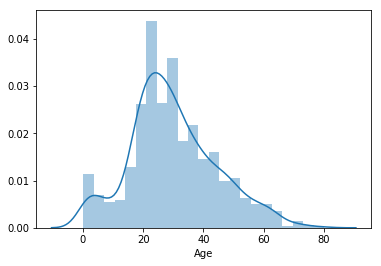

In [79]:
#Imputing Null in ages using fancyImpute

# Examine distribution of AGES prior to imputation for combined data (for comparison). 

null_ages = pd.isnull(combined_data.Age)
known_ages = pd.notnull(combined_data.Age)
initial_dist = combined_data.Age[known_ages]


sns.distplot(initial_dist)



In [80]:
#imputing AGE USING FANCYIMPUTE

from fancyimpute import SimpleFill
Xtmp = combined_data.drop(['PassengerId','Sex','Title','Cabin','Embarked'],axis=1)
Xtmp = pd.DataFrame(SimpleFill().fit_transform(Xtmp),index=Xtmp.index,columns=Xtmp.columns)
combined_data.loc[:,'Age'] = Xtmp.loc[:,'Age']


training_data = combined_data[:1100]
test_data = combined_data[1100:]

'''from fancyimpute import KNN

X_filled_knn = KNN(k=3).fit_transform(training_data_X)'''

'''def impute_ages(data):
    drop_survived = data.drop(['Survived'], axis=1)
    column_titles = list(drop_survived)
    mice_results = fancyimpute.MICE().fit_transform(drop_survived)
    results = pd.DataFrame(mice_results, columns=column_titles)
    results['Survived'] = list(data['Survived'])
    return results

complete_data = impute_ages(combined_data)
complete_data.Age = complete_data.Age[~(complete_data.Age).index.duplicated(keep='first')]
'''



"def impute_ages(data):\n    drop_survived = data.drop(['Survived'], axis=1)\n    column_titles = list(drop_survived)\n    mice_results = fancyimpute.MICE().fit_transform(drop_survived)\n    results = pd.DataFrame(mice_results, columns=column_titles)\n    results['Survived'] = list(data['Survived'])\n    return results\n\ncomplete_data = impute_ages(combined_data)\ncomplete_data.Age = complete_data.Age[~(complete_data.Age).index.duplicated(keep='first')]\n"

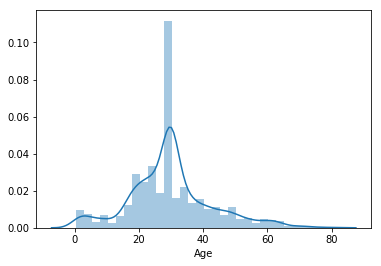

In [81]:
# Examine distribution of ages prior to imputation for training_data (for comparison).

null_ages = pd.isnull(training_data.Age)
known_ages = pd.notnull(training_data.Age)
initial_dist = training_data.Age[known_ages]

 
sns.distplot(initial_dist)

In [82]:
training_data['Age'].isnull().sum()

0

In [83]:
'''From the output above it is easy to see that distribution is not dramatically altered by the imputation. 
Additionally, there are no non-sensical ages (negative or extremely old) produced in the process. 
For experimenting with the tutorial this step is sufficent. 
In a more serious project this may be one of the most critical steps.'''

'From the output above it is easy to see that distribution is not dramatically altered by the imputation. \nAdditionally, there are no non-sensical ages (negative or extremely old) produced in the process. \nFor experimenting with the tutorial this step is sufficent. \nIn a more serious project this may be one of the most critical steps.'

In [84]:
test_data['Age'].isnull().sum()

0

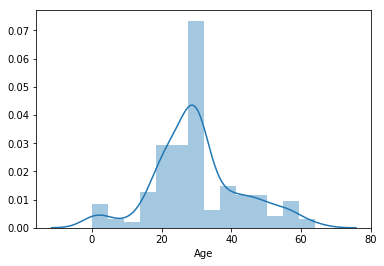

In [85]:
# Examine distribution of ages prior to imputation (for comparison).

null_ages = pd.isnull(test_data.Age)
known_ages = pd.notnull(test_data.Age)
initial_dist = test_data.Age[known_ages]

 
sns.distplot(initial_dist)

In [86]:
training_data.shape


(1100, 11)

In [87]:
test_data.shape

(209, 11)

In [88]:
#Split training_data and test_data again after Data CLeaning to prepare a model

training_data_Y=training_data["Survived"]
training_data_X = training_data.drop(["Survived"],axis = 1)

test_data_Y=test_data["Survived"]
test_data_X = test_data.drop(["Survived"],axis = 1)

In [89]:
training_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
Title          0
dtype: int64

In [90]:
test_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
Title          0
dtype: int64

In [91]:
'''Time for training the model and evaluating it on the validation set. 
At first, let's use the default values for the kNN hyperparameters -
n_neighbors = 3,weights = 'uniform'). KNN has more hyperparameters such as
leaf_size, metric, etc. But, these two are key hyperparamters'''

my_knn_model = KNeighborsClassifier(n_neighbors = 7,weights = 'uniform', metric='minkowski', leaf_size=30)
my_knn_model.fit(training_data_X,training_data_Y)

#Predict on the validation set
Y_pred = my_knn_model.predict(test_data_X )

In [92]:
print(accuracy_score(test_data_Y,Y_pred),
      matthews_corrcoef(test_data_Y,Y_pred),f1_score(test_data_Y,Y_pred))

0.569377990430622 0.05140560641943572 0.1
